In [49]:
from stock_indicators import indicators
from stock_indicators import Quote
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

from ta import add_all_ta_features
from ta.utils import dropna
import ta as ta

from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import *

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf

import statsmodels.api as sm


In [54]:
ticker ="PETR3.SA"


df = yf.download(ticker)

df = df["2018":"2022-03"]


# Create Training and Test
train = df["Close"].values[:round(len(df)*0.7)]
test = df["Close"].values[round(len(df)*0.7):]
test_index = df.index.values[round(len(df)*0.7):]

[*********************100%***********************]  1 of 1 completed


In [55]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name="Ação",
        x=df.index,
        y=df["Close"],
        line=dict(color='blue', width=1))
)

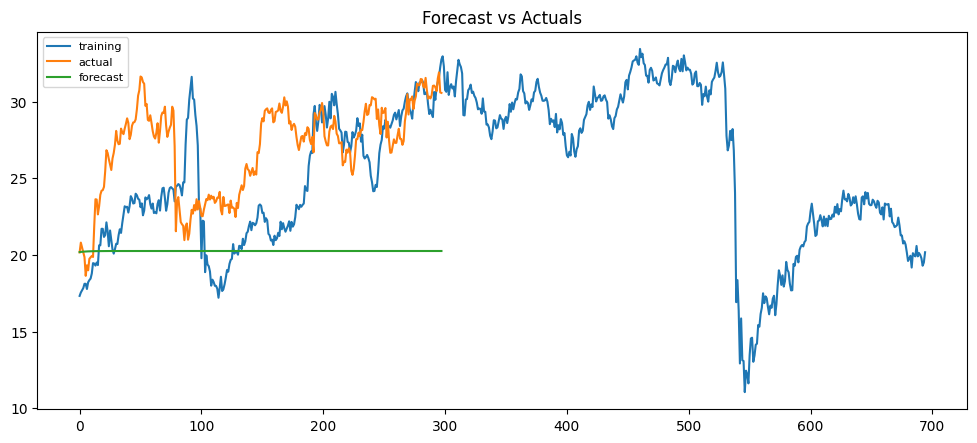

In [47]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = sm.tsa.arima.ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(len(test), alpha=0.05)  # 95% conf



# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [50]:
#TSI

tsi_config=[25,13]
resultados_tsi = ta.momentum.TSIIndicator(df["Close"],tsi_config[0],tsi_config[1],False)

resultados_tsi.tsi().dropna(inplace=True)


#Gaussian TSI
resultados_tsi_sem_null = resultados_tsi.tsi().dropna()

tsi_np = resultados_tsi_sem_null.to_numpy()

tsi_np = tsi_np.reshape(1,len(tsi_np))


smoother_tsi = GaussianSmoother(n_knots=60, sigma=0.0005)
smoother_tsi.smooth(tsi_np)


fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name="TSI",
        x=df.tail(len(resultados_tsi_sem_null)).index,
        y=resultados_tsi_sem_null,
        line=dict(color='blue', width=1))
)

fig.add_trace(
    go.Scatter(
        x=df.tail(len(resultados_tsi_sem_null)).index,
        y=smoother_tsi.smooth_data[0],
        mode='lines',
        name='Gaussian',
        line=dict(color="orange"))
)

In [51]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

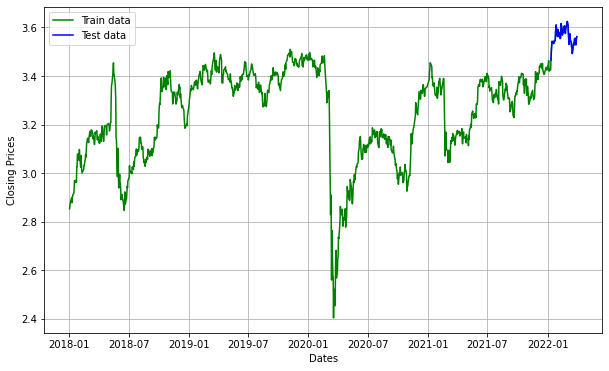

In [63]:
df_close = df['Close']
df_log = np.log(df_close)

train_data, test_data = df_log[3:int(len(df_log)*0.947)], df_log[int(len(df_log)*0.947):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5153.913, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3950.992, Time=0.57 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3954.251, Time=0.55 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2538.402, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.73 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-3961.242, Time=0.64 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1508.105, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.97 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-3971.798, Time=0.65 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2786.461, Time=0.68 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3963.599, Time=1.31 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3975.513,

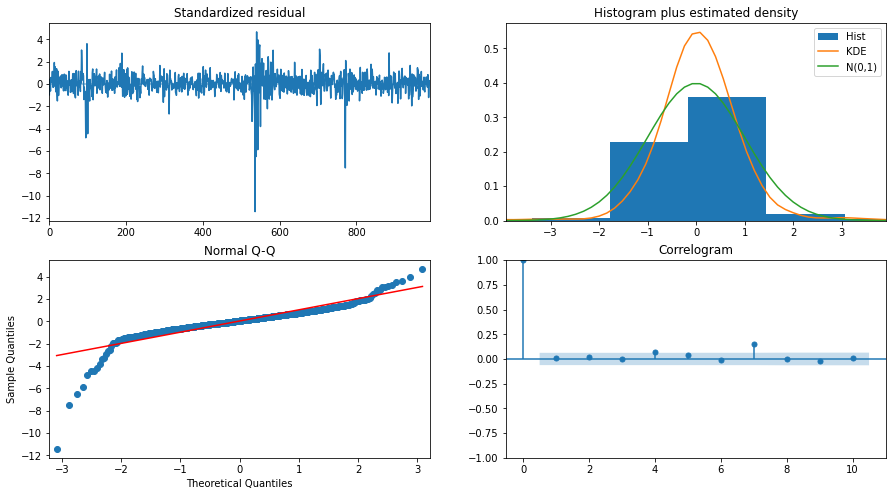

In [64]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [67]:
model = sm.tsa.arima.ARIMA(train_data, order=(2,0,3))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  992
Model:                 ARIMA(2, 0, 3)   Log Likelihood                1994.752
Date:                Tue, 07 Feb 2023   AIC                          -3975.505
Time:                        16:18:08   BIC                          -3941.207
Sample:                             0   HQIC                         -3962.464
                                - 992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2103      0.235     13.688      0.000       2.751       3.670
ar.L1          0.3307      0.064      5.166      0.000       0.205       0.456
ar.L2          0.6621      0.061     10.833      0.0

<Figure size 1000x500 with 0 Axes>

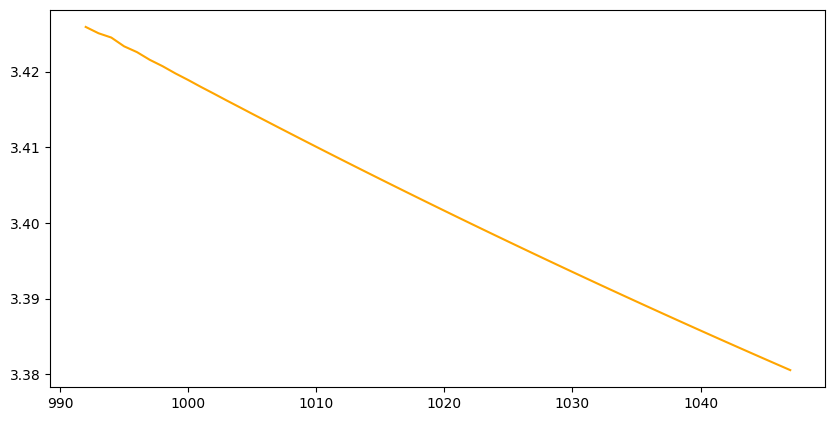

<Figure size 1000x500 with 0 Axes>

In [83]:
fc = fitted.forecast(len(test_data))
plt.figure(figsize=(10,5), dpi=100)
plt.plot(fc, color = 'orange',label='Predicted Stock Price')
plt.figure(figsize=(10,5), dpi=100)

In [ ]:
#ARIMA COM TSI

In [84]:
tsi_suavizado = smoother_tsi.smooth_data[0]

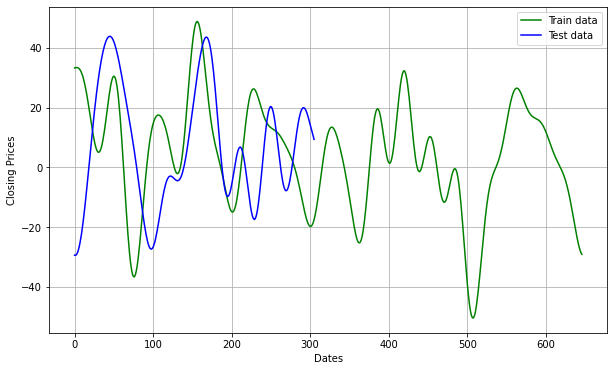

In [103]:
train_data, test_data = tsi_suavizado[3:int(len(tsi_suavizado)*0.68)], tsi_suavizado[int(len(tsi_suavizado)*0.68):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [104]:
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  647
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 993.668
Date:                Tue, 07 Feb 2023   AIC                          -1979.335
Time:                        16:31:20   BIC                          -1961.452
Sample:                             0   HQIC                         -1972.397
                                - 647                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9915      0.005    192.420      0.000       0.981       1.002
ma.L1          1.9936      0.389      5.124      0.000       1.231       2.756
ma.L2          0.9977      0.406      2.458      0.0

<Figure size 1000x500 with 0 Axes>

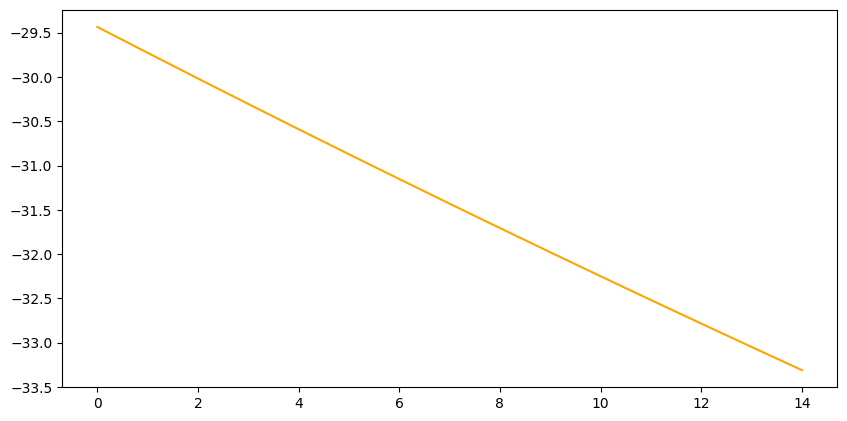

<Figure size 1000x500 with 0 Axes>

In [105]:
fc = fitted.forecast(15)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(fc, color = 'orange',label='Predicted Stock Price')
plt.figure(figsize=(10,5), dpi=100)